In [23]:
%load_ext autoreload
%autoreload 2

from sklearn.pipeline import Pipeline

from drift_ml.datasets.bosch_cnc_machining.models.nnclassifier import NNClassifier
from drift_ml.datasets.bosch_cnc_machining.utils.experiment import DriftExperiment
from drift_ml.datasets.bosch_cnc_machining.utils.dataloader import DriftDataLoader, NPYBoschCNCDataLoader, Standardizer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
base_loader = NPYBoschCNCDataLoader(metadata_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/metadata_ws4096.pkl")
base_loader.load_data(
    sample_data_x_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_x_raw_ws4096.npy",
    sample_data_y_path="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/extracted_features/npy/sample_data_y_raw_ws4096.npy"
    )

In [77]:
sudden_config = {
    "mode": {
        "features": "stft",
        "featureset": None
    },
    "base_config": {
        "train_size": 0.3,
        "val_size": 0.2,  # todo
        "test_size": 0.5,
        "machines": None,
        "processes": None,
        "periods": ["Feb_2019", "Aug_2019", "Feb_2020"],
    },
    "drift_config": [
        {
            "length": 10000,
            "type": "constant",
            "only_test": True,  # todo: False,
            "machines": None,
            "processes": None,
            "periods":  ["Feb_2019", "Aug_2019", "Feb_2020"],
            "transform_fn": None,
        },
        {
            "length": 10000,
            "type": "constant",
            "only_test": True,  # todo: False,
            "machines": None,
            "processes": None,
            "periods":  ["Aug_2020", "Feb_2021", "Aug_2021"],
            "transform_fn": None# lambda x: augment_xyz_samples(x, pitch_deg=30),
        },
    ],
}

In [78]:
drift_dataloader = DriftDataLoader(baseloader=base_loader, config=sudden_config)
model = Pipeline([('standardizer', Standardizer()), ('cnn', NNClassifier())])

In [83]:
experiment = DriftExperiment(
    model,
    drift_dataloader,
    chunksize=10000,
    window_size=1000,
    name="test_run",
    result_dir="/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/experiment_results",
    length=20000,
    fit_model=True,
)

In [84]:
experiment.run()

INFO:root:Doing the initial training of the model.
DEBUG:root:Starting training with batch size 128, lrate 0.01, epochs 20


Training NN:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

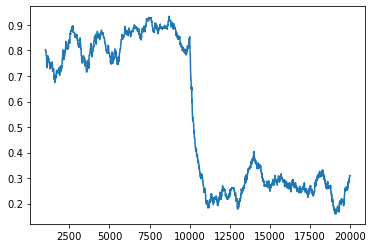

In [85]:
import matplotlib.pyplot as plt
plt.plot(experiment.metric_results_pred["mcc"])

In [54]:
X_train_raw, y_train = drift_dataloader.access_base_samples(dataset="train")
X_val_raw, y_val = drift_dataloader.access_base_samples(dataset="val")

standardizer = Standardizer()
X_train = standardizer.fit_transform(X_train_raw)
X_val = standardizer.transform(X_val_raw)

In [64]:
cnn = NNClassifier()
cnn.fit(X_train, y_train, val_X=X_val, val_y=y_val, lrate=1e-2)

DEBUG:root:Starting training with batch size 128, lrate 0.01, epochs 20


Training NN:   0%|          | 0/20 [00:00<?, ?it/s]

/home/tbiegel/nico_files/cms_2023_code/drift_ml/src/drift_ml/datasets/bosch_cnc_machining/models/nnclassifier.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor(X).to(self.device).float(),
DEBUG:root:Final val. performance: AUROC 0.96, AURPC 0.93, F1 0.86
